Setup & Test(Inference)

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, BatchNormalization, Activation,
    Dropout, LSTM, Embedding, Concatenate, TimeDistributed, Dense,
    Bidirectional, Attention
)
from tensorflow.keras.utils import Sequence

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

WORDLIST_FILE = "../DL-SCA/bip39_english.c"
MODEL_SAVE_DIR = "../DL-SCA/models/"
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, "best_model.keras")

TEST_TRACE_GROUPS = [
    ("../datasets/traces/filtered_trace_D_d_20000.npy", 0, False), 
]
TEST_MNEMONIC_FILES = [
    "../datasets/keys/mnemonic_code_d_20000.txt",
]

DECODER_STEPS = 24
ROI_START = 70000
WINDOW_LENGTH = 128000
BATCH_SIZE = 64
JITTER_MAX = 1000  

2026-01-15 09:49:59.404196: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 09:49:59.445024: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-15 09:50:00.402033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-15 09:50:00.410878: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devi

In [2]:
def load_bip39_wordlist_from_c(filepath: str):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")
    with open(filepath, "r", encoding="utf-8") as f:
        src = f.read()
    m = re.search(r"BIP39_WORDLIST_ENGLISH\s*\[.*?\]\s*=\s*\{", src)
    if not m: raise RuntimeError("BIP39 Array Not Found")
    start, end = m.end(), src.find("};", m.end())
    words = re.findall(r'"([a-z]+)"', src[start:end])
    return words[:2048]

def load_mnemonic_labels(txt_path: str, word_to_idx: dict, max_words=24):
    labels = []
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            words = line.split()
            if len(words) != max_words: continue
            labels.append([word_to_idx[w] for w in words])
    return np.array(labels, dtype=np.int32)

def build_table_spec_model(input_len, num_words, seq_len=24):
    inp_wave = Input(shape=(input_len, 1), name='waveform_input')
    
    x = Conv1D(32, 11, strides=2, padding='same')(inp_wave)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x) 
    x = Conv1D(64, 11, strides=2, padding='same')(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x) 
    x = Conv1D(128, 9, strides=2, padding='same')(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x) 
    x = Conv1D(256, 7, strides=2, padding='same')(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x) 
    
    x = Dropout(0.3)(x)
    encoder_output = Bidirectional(LSTM(128, return_sequences=True))(x)

    inp_pos = Input(shape=(seq_len,), name='position_input')
    pos_emb = Embedding(input_dim=seq_len, output_dim=256)(inp_pos)
    decoder_lstm_out = LSTM(256, return_sequences=True)(pos_emb)
    
    attention_layer = Attention(score_mode='dot')
    context_vector = attention_layer([decoder_lstm_out, encoder_output])
    
    concat_out = Concatenate()([decoder_lstm_out, context_vector])
    
    out = TimeDistributed(Dense(num_words, activation='softmax', dtype='float32'), name='word_output')(concat_out)
    
    model = Model(inputs=[inp_wave, inp_pos], outputs=out)
    return model

class SCADeterministicGenerator(Sequence):
    def __init__(self, metadata, arrays, batch_size=32, dim=128000, 
                 n_channels=1, seq_len=24, augment=True, roi_start=70000, jitter_max=1000):
        self.metadata = metadata
        self.arrays = arrays
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.seq_len = seq_len
        self.augment = augment 
        self.roi_start = roi_start
        self.jitter_max = jitter_max

    def __len__(self):
        return int(np.ceil(len(self.metadata) / self.batch_size))

    def __getitem__(self, index):
        batch_meta = self.metadata[index * self.batch_size:(index + 1) * self.batch_size]
        X_wave, X_pos, y = self.__data_generation(batch_meta)
        return {"waveform_input": X_wave, "position_input": X_pos}, y

    def __data_generation(self, batch_meta):
        actual_len = len(batch_meta)
        X_wave = np.empty((actual_len, self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((actual_len, self.seq_len), dtype=np.int32)
        X_pos = np.tile(np.arange(self.seq_len), (actual_len, 1)).astype(np.int32)

        for i, (g_idx, t_idx, label, _) in enumerate(batch_meta):
            raw_full = self.arrays[g_idx][t_idx] 
            
            current_start = self.roi_start
            if self.augment:
                unique_seed = (int(g_idx) * 1_000_000 + int(t_idx)) & 0xFFFFFFFF
                rng = np.random.default_rng(unique_seed)
                shift = rng.integers(-self.jitter_max, self.jitter_max + 1)
                current_start += shift

            if current_start < 0: current_start = 0
            max_start = len(raw_full) - self.dim
            if current_start > max_start: current_start = max_start

            segment = raw_full[current_start : current_start + self.dim].copy()
            
            mean = np.mean(segment)
            std = np.std(segment)
            if std > 1e-8: segment = (segment - mean) / std
            else: segment = segment - mean
            
            X_wave[i] = np.expand_dims(segment, axis=-1).astype(np.float32)
            y[i] = label
            
        return X_wave, X_pos, y

In [3]:
bip39_words = load_bip39_wordlist_from_c(WORDLIST_FILE)
word_to_idx = {w: i for i, w in enumerate(bip39_words)}
idx_to_word = {i: w for i, w in enumerate(bip39_words)}
NUM_KEYS = len(bip39_words)

loaded_arrays = []
for path, _, _ in TEST_TRACE_GROUPS:
    if os.path.exists(path):
        loaded_arrays.append(np.load(path, mmap_mode='r'))
        print(f"File loaded: {path}")
    else:
        print(f"❌ File not found: {path}")
        loaded_arrays.append(None)

test_labels = load_mnemonic_labels(TEST_MNEMONIC_FILES[0], word_to_idx)

test_metadata = []
num_traces = min(len(loaded_arrays[0]), len(test_labels))
for i in range(num_traces):
    test_metadata.append((0, i, test_labels[i], False))

print(f"Total test samples: {len(test_metadata)}")

File loaded: ../datasets/traces/filtered_trace_D_d_20000.npy
Total test samples: 20000


In [4]:
# Gerating test data generator with augmentation and jitter
test_gen = SCADeterministicGenerator(
    test_metadata, loaded_arrays, 
    batch_size=BATCH_SIZE, 
    seq_len=DECODER_STEPS, 
    augment=True, 
    roi_start=ROI_START,
    jitter_max=JITTER_MAX
)

print(">>> Model loading...")
model = build_table_spec_model(WINDOW_LENGTH, NUM_KEYS, DECODER_STEPS)
if os.path.exists(BEST_MODEL_PATH):
    model.load_weights(BEST_MODEL_PATH)
    print("Best Model Weights Loaded")
else:
    print(f"❌ No weights file found: {BEST_MODEL_PATH}")


print(f">>> Starting inference (Batch Processing, Jitter Max: {JITTER_MAX})...")

y_pred_indices_list = []
y_pred_conf_list = []
total_batches = len(test_gen)

for i in range(total_batches):
    batch_data, _ = test_gen[i] # (InputDict, Label)
    
    batch_preds = model.predict_on_batch(batch_data) # Shape: (Batch, 24, 2048)
    

    batch_indices = np.argmax(batch_preds, axis=-1) # Shape: (Batch, 24)
    batch_conf = np.max(batch_preds, axis=-1)       # Shape: (Batch, 24)
    
    y_pred_indices_list.append(batch_indices)
    y_pred_conf_list.append(batch_conf)
    
    print(f"Processing batch {i+1}/{total_batches}...", end='\r')

y_pred_indices = np.concatenate(y_pred_indices_list, axis=0)
y_pred_conf = np.concatenate(y_pred_conf_list, axis=0)

n_samples = min(len(y_pred_indices), len(test_labels))
y_pred_indices = y_pred_indices[:n_samples]
y_pred_conf = y_pred_conf[:n_samples]
y_true = test_labels[:n_samples]

print(f"\nInference completed. Total {n_samples} samples processed.")

2026-01-15 09:50:00.507126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-15 09:50:00.507177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-15 09:50:00.507191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-15 09:50:00.629910: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-15 09:50:00.629948: I external/local_xla/xla/stream_executor

>>> Model loading...
Best Model Weights Loaded
>>> Starting inference (Batch Processing, Jitter Max: 1000)...


2026-01-15 09:50:01.396350: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


Processing batch 313/313...
Inference completed. Total 20000 samples processed.


Performance Evaluation: Best vs. Worst Word Prediction Accuracy


[Result Summary] (Jitter Max: 1000)
1. Overall Accuracy: 99.41%
2. Perfect Match (24/24): 17455 / 20000
   -> Probability: 87.28%
3. Imperfect Match: 22.88 / 24

 Average word accuracy (Best 5 -> ... -> Worst 5) [Perfect Gap Fix]...
Saved: 'figure_acc_per_word.pdf'


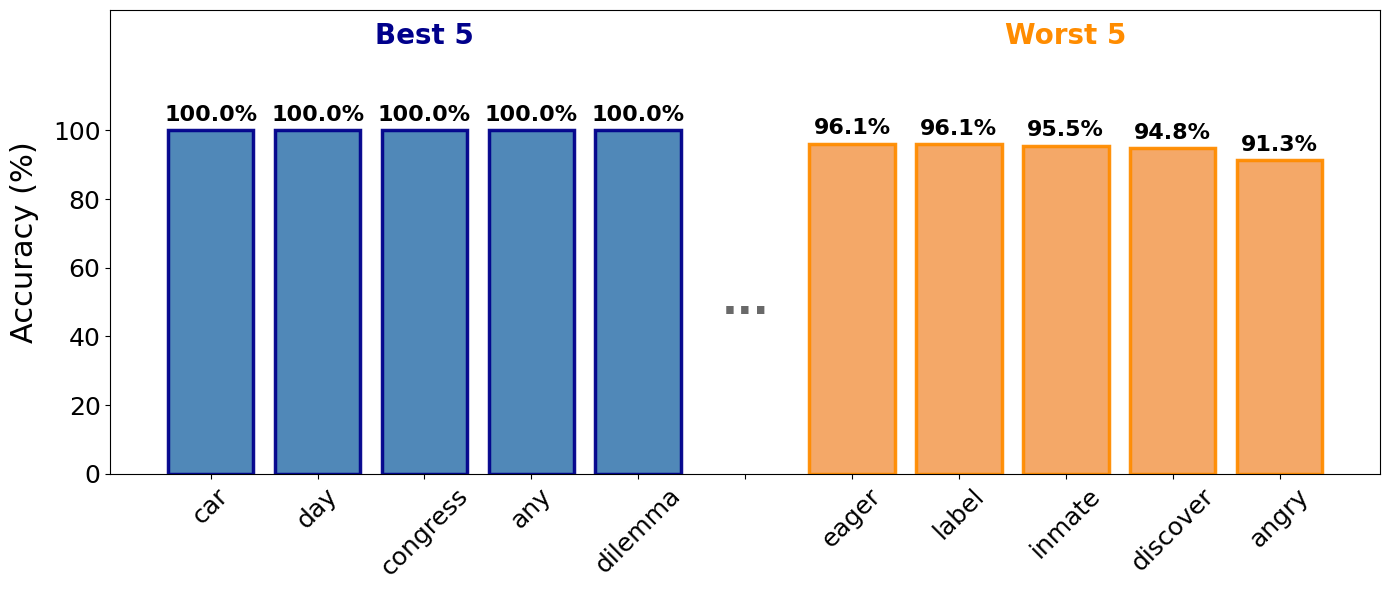

Best 5 Words:
    Word  Count  Accuracy
     car    286       1.0
     day    273       1.0
congress    272       1.0
     any    271       1.0
 dilemma    271       1.0

Worst 5 Words:
    Word  Count  Accuracy
   eager    258  0.961240
   label    256  0.960938
  inmate    224  0.955357
discover    233  0.948498
   angry    219  0.913242


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

matches = (y_pred_indices == y_true)
avg_acc = np.mean(matches)
correct_counts_per_sample = np.sum(matches, axis=1)
perfect_matches = np.sum(correct_counts_per_sample == 24)
perfect_ratio = (perfect_matches / n_samples) * 100

imperfect_indices = correct_counts_per_sample < 24
imperfect_counts = correct_counts_per_sample[imperfect_indices]

if len(imperfect_counts) > 0:
    avg_imperfect_correct = np.mean(imperfect_counts)
else:
    avg_imperfect_correct = 0.0

print("\n" + "="*50)
print(f"[Result Summary] (Jitter Max: {JITTER_MAX})")
print("="*50)
print(f"1. Overall Accuracy: {avg_acc * 100:.2f}%")
print(f"2. Perfect Match (24/24): {perfect_matches} / {n_samples}")
print(f"   -> Probability: {perfect_ratio:.2f}%")
print(f"3. Imperfect Match: {avg_imperfect_correct:.2f} / 24")
print("="*50)

print("\n Average word accuracy (Best 5 -> ... -> Worst 5) [Perfect Gap Fix]...")

y_true_flat = y_true.flatten()
y_pred_flat = y_pred_indices.flatten()

df_compare = pd.DataFrame({'True': y_true_flat, 'Pred': y_pred_flat})
df_compare['Correct'] = (df_compare['True'] == df_compare['Pred'])

stats = df_compare.groupby('True')['Correct'].agg(['count', 'mean']).reset_index()
stats.columns = ['WordIdx', 'Count', 'Accuracy']
stats['Word'] = stats['WordIdx'].apply(lambda x: idx_to_word.get(x, f"Unknown_{x}"))

df_sorted = stats.sort_values(by=['Accuracy', 'Count'], ascending=[False, False])
best_5 = df_sorted.head(5).copy()
worst_5 = df_sorted.tail(5).copy()

gap_data = pd.DataFrame([{
    'Word': '', 'Count': 0, 'Accuracy': 0, 'Type': 'Gap', 'WordIdx': -1
}])

plot_df = pd.concat([best_5, gap_data, worst_5], ignore_index=True)

plt.figure(figsize=(14, 6)) 


fill_colors = ['steelblue'] * 5 + ['white'] + ['sandybrown'] * 5
edge_colors = ['darkblue'] * 5 + ['white'] + ['darkorange'] * 5
# -----------------------------------------------

bars = plt.bar(range(len(plot_df)), plot_df['Accuracy'] * 100,
               color=fill_colors, edgecolor=edge_colors, linewidth=2.5, alpha=0.95)

gap_index = 5
bars[gap_index].set_visible(False)

labels = plot_df['Word'].tolist()

plt.xticks(range(len(plot_df)), labels, rotation=45, ha='center', fontsize=18)

plt.ylabel('Accuracy (%)', fontsize=22, labelpad=10)
plt.yticks(range(0, 101, 20), fontsize=18)
plt.ylim(0, 135)

plt.text(gap_index, 50, "...", ha='center', va='center', fontsize=30, fontweight='bold', color='dimgray')

plt.text(2, 125, "Best 5", ha='center', fontsize=20, fontweight='bold', color='darkblue')
plt.text(8, 125, "Worst 5", ha='center', fontsize=20, fontweight='bold', color='darkorange')

for i, bar in enumerate(bars):
    if i == gap_index: continue
    
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1.5,
             f'{height:.1f}%', ha='center', va='bottom',
             fontsize=16, fontweight='bold', color='black')

plt.tight_layout()

save_filename = 'figure_acc_per_word.pdf'
plt.savefig(save_filename, dpi=300) 
print(f"Saved: '{save_filename}'")
plt.show()

print("Best 5 Words:")
print(best_5[['Word', 'Count', 'Accuracy']].to_string(index=False))
print("\nWorst 5 Words:")
print(worst_5[['Word', 'Count', 'Accuracy']].to_string(index=False))

Case Study: Visualizing Misclassification

Finding samples with 23/24 accuracy...
Target index: 22
--------------------------------------------------------------------------------
Sample 22 Analysis
--------------------------------------------------------------------------------
Pos  | Pred   | Conf       | True   | Status
--------------------------------------------------------------------------------
1    | 632    | 0.6268     | 632    | OK
2    | 340    | 0.5039     | 340    | OK
3    | 1061   | 0.2441     | 1061   | OK
4    | 325    | 0.6505     | 325    | OK
5    | 605    | 0.6472     | 605    | OK
6    | 1960   | 0.2145     | 1960   | OK
7    | 1090   | 0.6319     | 1090   | OK
8    | 1892   | 0.5406     | 1892   | OK
9    | 180    | 0.0388     | 176    | [ERROR]
10   | 735    | 0.6444     | 735    | OK
11   | 5      | 0.4917     | 5      | OK
12   | 41     | 0.6431     | 41     | OK
13   | 1892   | 0.7671     | 1892   | OK
14   | 1068   | 0.3238     | 1068   | OK
15   | 753    | 0.4425     | 753    | OK
16   | 612    | 0

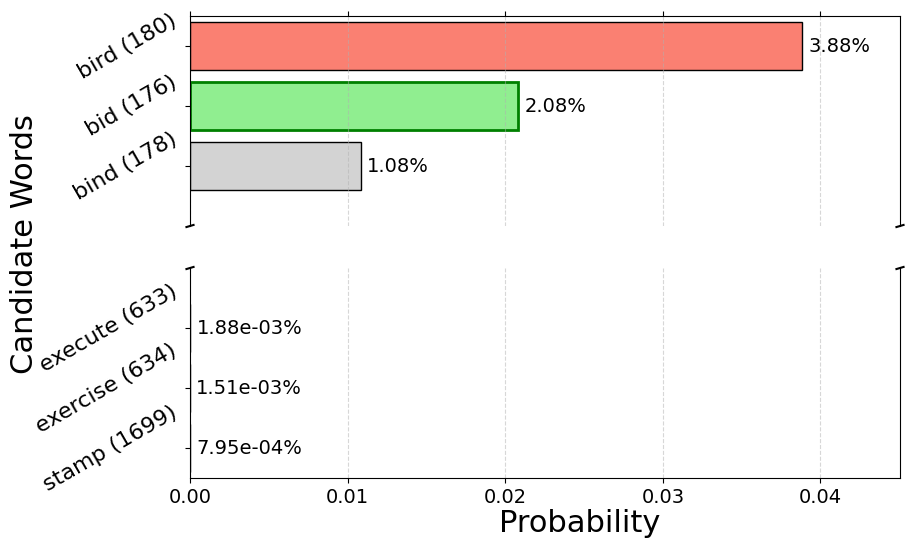

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# =============================================================================
# 6. Analyze Single-Error Samples (23/24)
# =============================================================================
print("Finding samples with 23/24 accuracy...")

one_error_indices = np.where(correct_counts_per_sample == 23)[0]

if len(one_error_indices) == 0:
    print("No samples found.")
else:
    target_idx = one_error_indices[0]
    print(f"Target index: {target_idx}")
    
    t_row = y_true[target_idx]
    p_row = y_pred_indices[target_idx]
    
    batch_idx = target_idx // BATCH_SIZE
    in_batch_idx = target_idx % BATCH_SIZE
    
    # Inference
    batch_data = test_gen[batch_idx]
    sample_input = {
        'waveform_input': batch_data[0]['waveform_input'][in_batch_idx:in_batch_idx+1],
        'position_input': batch_data[0]['position_input'][in_batch_idx:in_batch_idx+1]
    }
    
    probs_sample = model.predict(sample_input, verbose=0)
    c_row = np.max(probs_sample[0], axis=-1)

    # Print results
    print("-" * 80)
    print(f"Sample {target_idx} Analysis")
    print("-" * 80)
    print(f"{'Pos':<4} | {'Pred':<6} | {'Conf':<10} | {'True':<6} | {'Status'}")
    print("-" * 80)
    
    error_pos = -1
    for i in range(24):
        p_idx = p_row[i]
        t_idx = t_row[i]
        prob = c_row[i]
        
        if p_idx != t_idx:
            error_pos = i
            status = "[ERROR]"
        else:
            status = "OK"
            
        print(f"{i+1:<4} | {p_idx:<6} | {prob:.4f}     | {t_idx:<6} | {status}")
            
    print("-" * 80)
    
    # -----------------------------------------------------
    # Visualization
    # -----------------------------------------------------
    print(f"Plotting error distribution for pos {error_pos + 1}...")
    
    target_probs = probs_sample[0][error_pos]
    
    # Sort desc
    sorted_indices = np.argsort(target_probs)[::-1]
    sorted_probs = target_probs[sorted_indices]
    
    # Select top/bottom 3
    top_indices = sorted_indices[:3]
    top_probs = sorted_probs[:3]
    top_labels = [f"{idx_to_word.get(i, 'UNK')} ({i})" for i in top_indices]
    
    bot_indices = sorted_indices[-3:]
    bot_probs = sorted_probs[-3:]
    bot_labels = [f"{idx_to_word.get(i, 'UNK')} ({i})" for i in bot_indices]
    
    # Set colors
    top_colors = ['salmon'] + ['lightgray'] * 2
    bot_colors = ['lightgray'] * 3
    
    true_idx = t_row[error_pos]
    
    for i, idx in enumerate(top_indices):
        if idx == true_idx: top_colors[i] = 'lightgreen'
    for i, idx in enumerate(bot_indices):
        if idx == true_idx: bot_colors[i] = 'lightgreen'

    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1]})
    max_prob = top_probs[0]
    
    # Top bar
    bars1 = ax1.barh(top_labels[::-1], top_probs[::-1], color=top_colors[::-1], edgecolor='black')
    for i, idx in enumerate(top_indices[::-1]):
        if idx == true_idx:
            bars1[i].set_edgecolor('green')
            bars1[i].set_linewidth(2)
            
    for bar in bars1:
        width = bar.get_width()
        ax1.text(width + max_prob*0.01, bar.get_y() + bar.get_height()/2, 
                 f'{width*100:.2f}%', va='center', fontsize=14)

    # Bottom bar
    bars2 = ax2.barh(bot_labels[::-1], bot_probs[::-1], color=bot_colors[::-1], edgecolor='black')
    for i, idx in enumerate(bot_indices[::-1]):
        if idx == true_idx:
            bars2[i].set_edgecolor('green')
            bars2[i].set_linewidth(2)

    for bar in bars2:
        width = bar.get_width()
        label_text = f'{width*100:.2e}%' 
        ax2.text(width + max_prob*0.01, bar.get_y() + bar.get_height()/2, 
                 label_text, va='center', fontsize=14)

    # Style axes
    ax1.set_ylim(-1.0, 2.5) 
    ax2.set_ylim(-0.5, 3.0) 

    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False, bottom=False)
    ax2.xaxis.tick_bottom()
    ax2.tick_params(top=False) 

    # Broken axis lines
    d = .005 
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # Grid and ticks
    for ax in [ax1, ax2]:
        ax.set_xlim(0, max_prob * 1.16) 
        ax.tick_params(axis='y', labelsize=16, labelrotation=30)
        
        for label in ax.get_yticklabels():
            label.set_horizontalalignment('right')
            label.set_verticalalignment('center')

        ax.grid(axis='x', linestyle='--', alpha=0.5)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
    
    ax2.tick_params(axis='x', labelsize=14)
    
    plt.subplots_adjust(left=0.19, hspace=0.2)
    
    fig.text(0.58, 0.02, 'Probability', ha='center', fontsize=22)
    fig.text(0.01, 0.5, 'Candidate Words', va='center', rotation='vertical', fontsize=22)
    
    # Save
    err_filename = f'figure_test_one_error.pdf'
    plt.savefig(err_filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {err_filename}")
    
    plt.show()

Evaluation of Word Prediction Accuracy by Position


Analyzing positional accuracy (Y-range: 98-99.7%)...

Positional Accuracy stats:
----------------------------------------
Pos 01 : 98.6350%
Pos 02 : 99.4350%
Pos 03 : 99.3850%
Pos 04 : 99.5150%
Pos 05 : 99.4000%
Pos 06 : 99.0750%
Pos 07 : 99.4250%
Pos 08 : 99.4750%
Pos 09 : 99.5100%
Pos 10 : 99.4850%
Pos 11 : 99.4600%
Pos 12 : 99.4900%
Pos 13 : 99.5300%
Pos 14 : 99.4650%
Pos 15 : 99.5200%
Pos 16 : 99.4600%
Pos 17 : 99.4600%
Pos 18 : 99.4750%
Pos 19 : 99.4750%
Pos 20 : 99.4900%
Pos 21 : 99.3650%
Pos 22 : 99.4700%
Pos 23 : 99.3950%
Pos 24 : 99.3600%
----------------------------------------
Mean across 24 positions : 99.4065%
----------------------------------------

Saved plot to 'figure_acc_per_position.pdf'


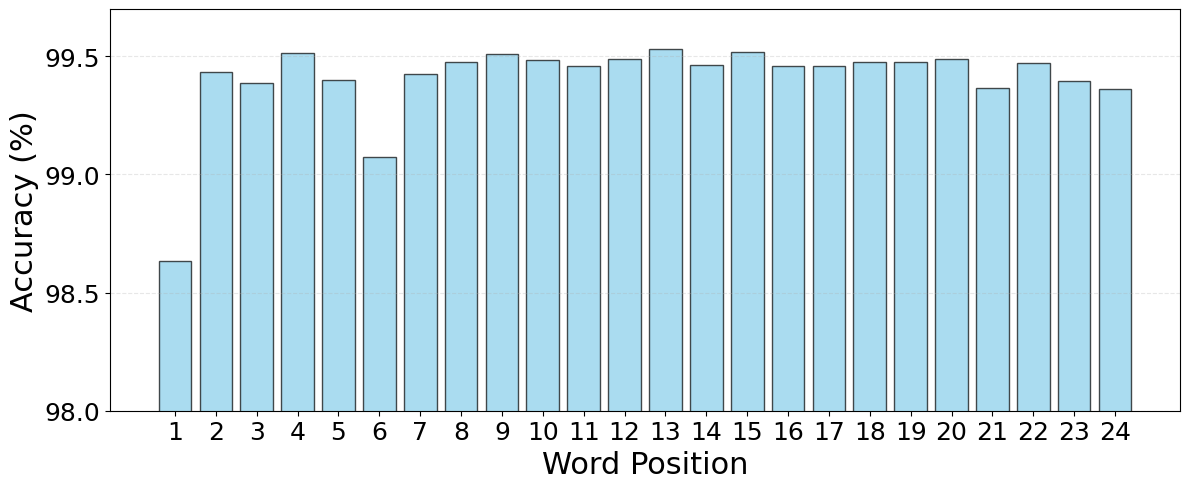

In [7]:
import matplotlib.pyplot as plt
import numpy as np

print("\nAnalyzing positional accuracy (Y-range: 98-99.7%)...")

# 1. Calculate accuracy per position
# Assumes y_pred_indices and y_true are defined (shape: (N, 24))
matches = (y_pred_indices == y_true)
position_acc = np.mean(matches, axis=0) * 100 

# -------------------------------------------------------------------------
# Print detailed mean accuracy per position
# -------------------------------------------------------------------------
print("\nPositional Accuracy stats:")
print("-" * 40)
for i, acc in enumerate(position_acc):
    print(f"Pos {i+1:02d} : {acc:.4f}%")
print("-" * 40)
# Overall mean across all positions
print(f"Mean across 24 positions : {np.mean(position_acc):.4f}%")
print("-" * 40)
# -------------------------------------------------------------------------

# 2. Setup figure
plt.figure(figsize=(12, 5))

# 3. Plot bar chart
plt.bar(range(1, 25), position_acc, color='skyblue', edgecolor='black', alpha=0.7)

# Optional: line plot overlay
# plt.plot(range(1, 25), position_acc, color='#d62728', marker='o', linestyle='-', linewidth=2, markersize=6)

# -------------------------------------------------------------------------
# Clip Y-axis to focus on high accuracy range (98.0 - 99.7)
# -------------------------------------------------------------------------
plt.ylim(98, 99.7) 
plt.yticks([98, 98.5, 99, 99.5])

# X-axis ticks (1~24)
plt.xticks(range(1, 25))

# -------------------------------------------------------------------------
# Increase font sizes for paper readability (Labels & Ticks)
# -------------------------------------------------------------------------
# Labels (Bold, size 22)
plt.xlabel('Word Position', fontsize=22)
plt.ylabel('Accuracy (%)', fontsize=22)

# Ticks (size 18)
plt.tick_params(axis='both', which='major', labelsize=18)

# Add grid
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# 7. Save high-res figure
save_filename_pos = 'figure_acc_per_position.pdf'
plt.savefig(save_filename_pos, dpi=300, bbox_inches='tight')
print(f"\nSaved plot to '{save_filename_pos}'")

plt.show()

# Check data range against plot limits
min_val = np.min(position_acc)
max_val = np.max(position_acc)
if min_val < 98:
    print(f"Warning: Min accuracy ({min_val:.2f}%) is below Y-axis limit (98%). Data clipped.")
if max_val > 99.7:
    print(f"Note: Max accuracy ({max_val:.2f}%) is above Y-axis limit (99.7%). Data clipped.")

Top-k Accuracy Analysis on Misclassified Tokens

In [8]:
import numpy as np
import math

# Identify samples that were not perfectly predicted
failed_indices = np.where(correct_counts_per_sample < 24)[0]
n_failed = len(failed_indices)

print(f"Number of non-perfect samples: {n_failed} / {len(correct_counts_per_sample)}")

if n_failed > 0:
    print("Starting batch inference to analyze Top-k accuracy on ERROR WORDS only...")

    SAFE_BATCH_SIZE = 16
    
    # Initialize counters
    top_k_hits = {2: 0, 3: 0, 5: 0}
    total_error_tokens = 0  # Denominator: Total count of incorrectly predicted words
    
    num_chunks = math.ceil(n_failed / SAFE_BATCH_SIZE)
    
    for chunk_i in range(num_chunks):
        start_idx = chunk_i * SAFE_BATCH_SIZE
        end_idx = min((chunk_i + 1) * SAFE_BATCH_SIZE, n_failed)
        
        current_batch_indices = failed_indices[start_idx:end_idx]
        
        batch_waveforms = []
        batch_positions = []
        batch_true_labels = []
        
        for global_idx in current_batch_indices:
            b_idx = global_idx // BATCH_SIZE
            in_b_idx = global_idx % BATCH_SIZE
            
            inputs = test_gen[b_idx][0]
            
            batch_waveforms.append(inputs['waveform_input'][in_b_idx])
            batch_positions.append(inputs['position_input'][in_b_idx])
            batch_true_labels.append(y_true[global_idx])
            
        x_batch = {
            'waveform_input': np.array(batch_waveforms),
            'position_input': np.array(batch_positions)
        }
        y_batch_true = np.array(batch_true_labels)
        
        # Inference
        probs = model.predict(x_batch, verbose=0)
        
        # 1. Identify which words were predicted incorrectly (Top-1 Error)
        pred_labels = np.argmax(probs, axis=-1)
        incorrect_mask = (pred_labels != y_batch_true)  # Boolean mask for errors (True if wrong)
        
        # Count total error tokens in this batch
        num_errors_in_batch = np.sum(incorrect_mask)
        total_error_tokens += num_errors_in_batch
        
        if num_errors_in_batch > 0:
            # 2. Check Top-k inclusion for these error words
            top5_preds = np.argsort(probs, axis=-1)[:, :, -5:]
            
            for k in [2, 3, 5]:
                # Get Top-k predictions
                top_k_subset = top5_preds[:, :, -k:]
                
                # Check if true label is in Top-k
                is_in_top_k = np.any(top_k_subset == y_batch_true[:, :, np.newaxis], axis=-1)
                
                # Only count hits where the word was actually wrong in Top-1
                # (Intersection of "Top-k has answer" AND "Top-1 was wrong")
                valid_hits = is_in_top_k & incorrect_mask
                top_k_hits[k] += np.sum(valid_hits)
            
        if (chunk_i + 1) % 50 == 0:
            print(f"Processed {chunk_i + 1}/{num_chunks} batches...")

    if total_error_tokens > 0:
        acc_results = {k: (top_k_hits[k] / total_error_tokens) * 100 for k in [2, 3, 5]}
        
        print("\n" + "="*50)
        print("Top-k Accuracy on Incorrect Predictions Only")
        print(f"(Total Error Tokens Analyzed: {total_error_tokens})")
        print("="*50)
        print(f"Top-2 Accuracy: {acc_results[2]:.2f}%")
        print(f"Top-3 Accuracy: {acc_results[3]:.2f}%")
        print(f"Top-5 Accuracy: {acc_results[5]:.2f}%")
        print("="*50)
    else:
        print("No error tokens found in the selected samples.")

else:
    print("No non-perfect samples found.")

Number of non-perfect samples: 2545 / 20000
Starting batch inference to analyze Top-k accuracy on ERROR WORDS only...
Processed 50/160 batches...
Processed 100/160 batches...
Processed 150/160 batches...

Top-k Accuracy on Incorrect Predictions Only
(Total Error Tokens Analyzed: 2849)
Top-2 Accuracy: 59.32%
Top-3 Accuracy: 72.97%
Top-5 Accuracy: 84.28%
